AI for Screening
================

In [1]:
import numpy as np
import pandas as pd
import glob

train = glob.glob('../input/train/**/*.jpg') + glob.glob('../input/additional/**/*.jpg')
train = pd.DataFrame([[p.split('/')[3],p.split('/')[4],p] for p in train], columns = ['type','image','path'])

test = glob.glob('../input/test/*.jpg')
test = pd.DataFrame([[p.split('/')[3],p] for p in test], columns = ['image','path'])

sub = pd.read_csv('../input/sample_submission.csv')
print(len(train),len(test),len(sub))

8215 512 512


In [2]:
test.head()

,image,path
0,0.jpg,../input/test/0.jpg
1,1.jpg,../input/test/1.jpg
2,10.jpg,../input/test/10.jpg
3,100.jpg,../input/test/100.jpg
4,101.jpg,../input/test/101.jpg


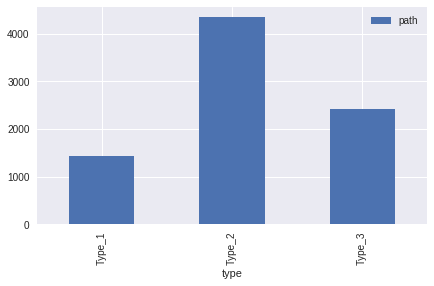

In [3]:
from PIL import ImageFilter, ImageStat, Image, ImageDraw
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cv2

types = train.groupby('type', as_index=False)['path'].count()
_ = types.plot(kind='bar', x='type', y='path', figsize=(7,4))

In [4]:
types

,type,path
0,Type_1,1441
1,Type_2,4348
2,Type_3,2426


../input/additional/Type_2/5892.jpg


../input/additional/Type_2/2845.jpg


../input/additional/Type_1/5893.jpg


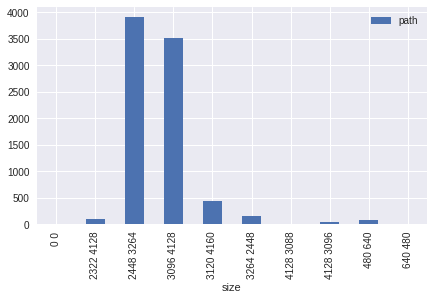

In [5]:
from multiprocessing import Pool, cpu_count

def im_multi(path):
    try:
        im_stats_im_ = Image.open(path)
        return [path, {'size': im_stats_im_.size}]
    except:
        print(path)
        return [path, {'size': [0,0]}]

def im_stats(im_stats_df):
    im_stats_d = {}
    p = Pool(cpu_count())
    ret = p.map(im_multi, im_stats_df['path'])
    for i in range(len(ret)):
        im_stats_d[ret[i][0]] = ret[i][1]
    im_stats_df['size'] = im_stats_df['path'].map(lambda x: ' '.join(str(s) for s in im_stats_d[x]['size']))
    return im_stats_df

train = im_stats(train)
sizes = train.groupby('size', as_index=False)['path'].count()
_ = sizes.plot(kind='bar', x='size', y='path', figsize=(7,4))

In [6]:
sizes

,size,path
0,0 0,3
1,2322 4128,94
2,2448 3264,3911
3,3096 4128,3508
4,3120 4160,430
5,3264 2448,157
6,4128 3088,1
7,4128 3096,38
8,480 640,72
9,640 480,1


In [7]:
train.head()

,type,image,path,size
0,Type_1,0.jpg,../input/train/Type_1/0.jpg,2448 3264
1,Type_1,10.jpg,../input/train/Type_1/10.jpg,3096 4128
2,Type_1,1013.jpg,../input/train/Type_1/1013.jpg,2448 3264
3,Type_1,1014.jpg,../input/train/Type_1/1014.jpg,3096 4128
4,Type_1,1019.jpg,../input/train/Type_1/1019.jpg,2448 3264


In [8]:
train.to_csv('train4.csv', index=False)

Train and Test
==============

In [9]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers

def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (64, 64), cv2.INTER_LINEAR)
    return [path, resized]

def normalize_image_features(paths):
    imf_d = {}
    p = Pool(cpu_count())
    ret = p.map(get_im_cv2, paths)
    for i in range(len(ret)):
        imf_d[ret[i][0]] = ret[i][1]
    ret = []
    fdata = [imf_d[f] for f in paths]
    fdata = np.array(fdata, dtype=np.uint8)
    fdata = fdata.transpose((0, 3, 1, 2))
    fdata = fdata.astype('float32')
    fdata = fdata / 255
    return fdata

#train = glob.glob('../input/train/**/*.jpg') + glob.glob('../input/additional/**/*.jpg')
print(len(train))
#train = pd.DataFrame([[p.split('/')[3],p.split('/')[4],p] for p in train], columns = ['type','image','path'])
train = train[train['size'] != '0 0'].reset_index(drop=True) #remove bad images
train_data = normalize_image_features(train['path'])
le = LabelEncoder()
train_target = le.fit_transform(train['type'].values)

Using TensorFlow backend.


8215


In [10]:
# Normalize test data
test_data = normalize_image_features(test['path'])
test_id = test.image.values  

import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, -1)
   
# Saving the processed data
save_object(train_data, 'processedTrainData_4.pkl')
save_object(train_target, 'processeTargetData_4.pkl')
save_object(test_data, 'processeTestData_4.pkl')

In [11]:
save_object(test_id, 'processeTestID_4.pkl')

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers

def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (64, 64), cv2.INTER_LINEAR)
    return [path, resized]

def normalize_image_features(paths):
    imf_d = {}
    p = Pool(cpu_count())
    ret = p.map(get_im_cv2, paths)
    for i in range(len(ret)):
        imf_d[ret[i][0]] = ret[i][1]
    ret = []
    fdata = [imf_d[f] for f in paths]
    fdata = np.array(fdata, dtype=np.uint8)
    fdata = fdata.transpose((0, 3, 1, 2))
    fdata = fdata.astype('float32')
    fdata = fdata / 255
    return fdata

#train = glob.glob('../input/train/**/*.jpg') + glob.glob('../input/additional/**/*.jpg')
print(len(train))
#train = pd.DataFrame([[p.split('/')[3],p.split('/')[4],p] for p in train], columns = ['type','image','path'])
train = train[train['size'] != '0 0'].reset_index(drop=True) #remove bad images
train_data = normalize_image_features(train['path'])
le = LabelEncoder()
train_target = le.fit_transform(train['type'].values)

# Normalize test data
test_data = normalize_image_features(test['path'])
test_id = test.image.values  

In [ ]:
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, -1)
   
# Save the processed data
save_object(train_data, 'processeTtrainData.pkl')
save_object(train_target, 'processeTargetData.pkl')
save_object(test_data, 'processeTestData.pkl')

In [ ]:
def create_model(opt_):
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, 64, 64), dim_ordering='th'))
    model.add(Convolution2D(8, 3, 3, activation='relu', dim_ordering='th'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))
    model.add(Dropout(0.2))
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='relu'))  
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=opt_, loss='categorical_crossentropy', metrics=['accuracy']) #loss='binary_crossentropy' not working
    return model

model = KerasClassifier(build_fn=create_model, nb_epoch=5, batch_size=20, verbose=2)
opts_ = ['adamax'] #['adadelta','sgd','adagrad','adam','adamax']
epochs = np.array([10])
batches = np.array([10])
param_grid = dict(nb_epoch=epochs, batch_size=batches, opt_=opts_)
grid = GridSearchCV(estimator=model, cv=StratifiedKFold(n_splits=2), param_grid=param_grid, verbose=20)
grid_result = grid.fit(train_data, train_target)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

test_data = normalize_image_features(test['path'])
test_id = test.image.values

pred = grid_result.predict_proba(test_data)
df = pd.DataFrame(pred, columns=le.classes_)
df['image_name'] = test_id
df.to_csv('submission.csv', index=False)

In [ ]:
df.head()